# Base Layer Matching PDAP Imagery

By default, the PDAP python interfaces return back images in top-of-atmosphere reflectance units.  While these are useful physical quantities, they can vary quite a bit between images which can complicate displaying them in pleasing ways.  Luckily TMS services such as DigitalGlobe's Maps API can have already done the hard work of producing color balanced images (via FLAME?).  We can leverage this work to make arbitrary images look attractive by histogram matching our images to the same region as delivered by Maps API.  

We'll use be using and rio_hist to accomplish this so first we have to install it.

In [1]:
!pip install -q rio_hist

Next we import a bunch of things that will be used later, and specify a Maps API key.

In [2]:
from functools import partial

from shapely.geometry import box, shape
from shapely import ops
import pyproj
import numpy as np
from rio_hist.match import histogram_match
import matplotlib.pyplot as plt
%matplotlib inline

from gbdxtools import CatalogImage, TmsImage

MAPS_API_KEY = "pk.eyJ1IjoiZGlnaXRhbGdsb2JlIiwiYSI6ImNqMXkyZXZsODAwYWszMmsyM3lvZHBzMWsifQ.EYqlvq6QWczWsvrEDDTf7g"

We've selected a region of the Outer Banks in North Carolina, and found the catalog ids for a few images that contain that region.

In [3]:
cat_ids = [u'103001006358E700',
 u'104001001DB34300',
 u'1030010033790D00',
 u'10300100277B6B00']

bounds = box(-75.4883909225464, 35.64135929710805, -75.46843528747559, 35.65959760189677)

Next we create a list of pansharpened CatalogImage instances that have been subsetted to the region we defined above.  Just for fun, we'll also reproject the images to web mercator (NOTE: taken out due to bug in older gbdxtools on juno).

In [12]:
images = []
for cat_id in cat_ids:
    try:
        images.append(CatalogImage(cat_id)[bounds])
    except Exception as e:
        print(e)
        print cat_id, "failed"

Finally we'll prepare a TmsImage instance that we'll use to access Maps API data.

In [8]:
tms = TmsImage(access_token=MAPS_API_KEY, zoom=18)

Now we're ready to histogram match.

## Histogram Matching

The function below uses rio_hist to match the image histogram to one accessed via Maps API.  Because we reprojected our images, their shapes are returned in web mercator coordinates.  The PDAP python interfaces will subset images by geometry, but require lat-long coordinates as input, so we also reproject based on the input images `__geo_transform__`.

In [9]:
def match_colors_to_ref(region):
    tfm = partial(pyproj.transform, 
              pyproj.Proj(init=region.__geo_transform__.proj), 
              pyproj.Proj(init="epsg:4326"))
    boundary = ops.transform(tfm, shape(region))
    tms_region = tms[boundary]
    data = region[[4,2,1],...].read()
    ref = tms_region.read()
    out = np.dstack([histogram_match(data[idx,:,:], ref[idx,:,:].astype(np.double)/255.0) 
                     for idx in xrange(data.shape[0])])
    return out

Finally, we can loop through our images and compare the normal, raw reflectance images with the results after base-layer matching.  Notice the improvement.

Fetching Image... 16 tiles


Fetching Image... 16 tiles


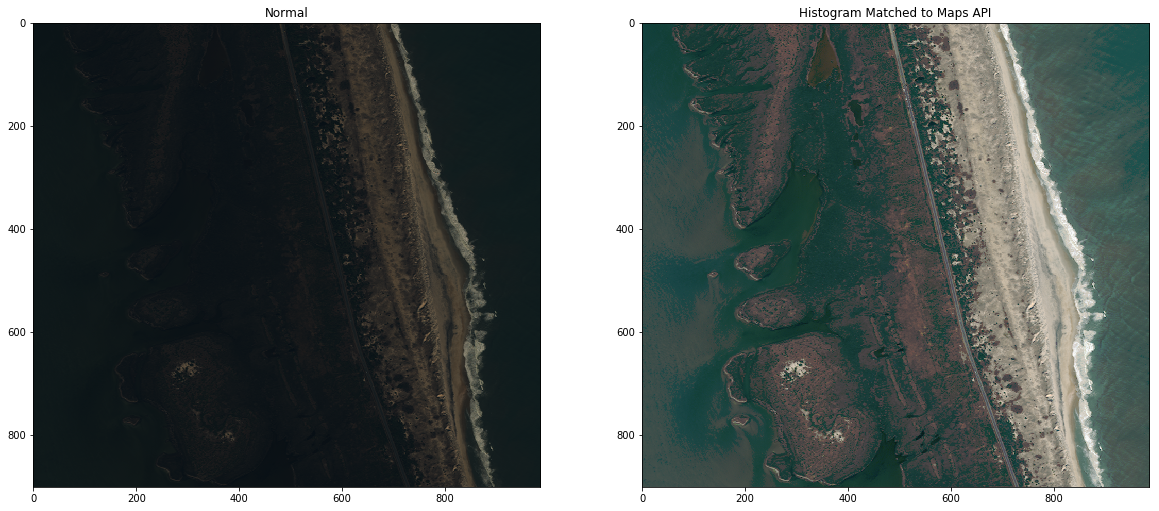

Fetching Image... 36 tiles


Fetching Image... 36 tiles


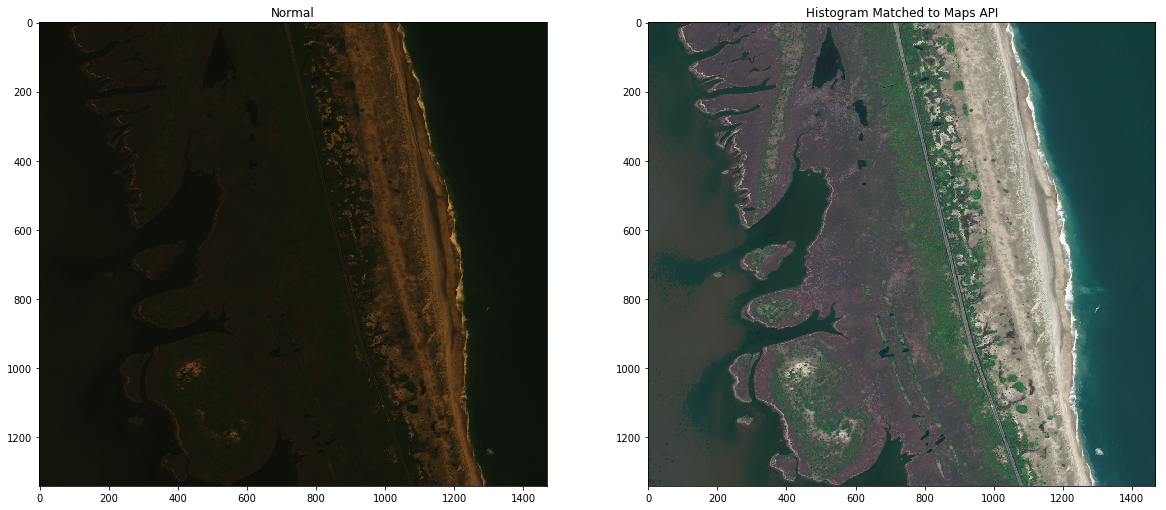

Fetching Image... 25 tiles


Fetching Image... 25 tiles


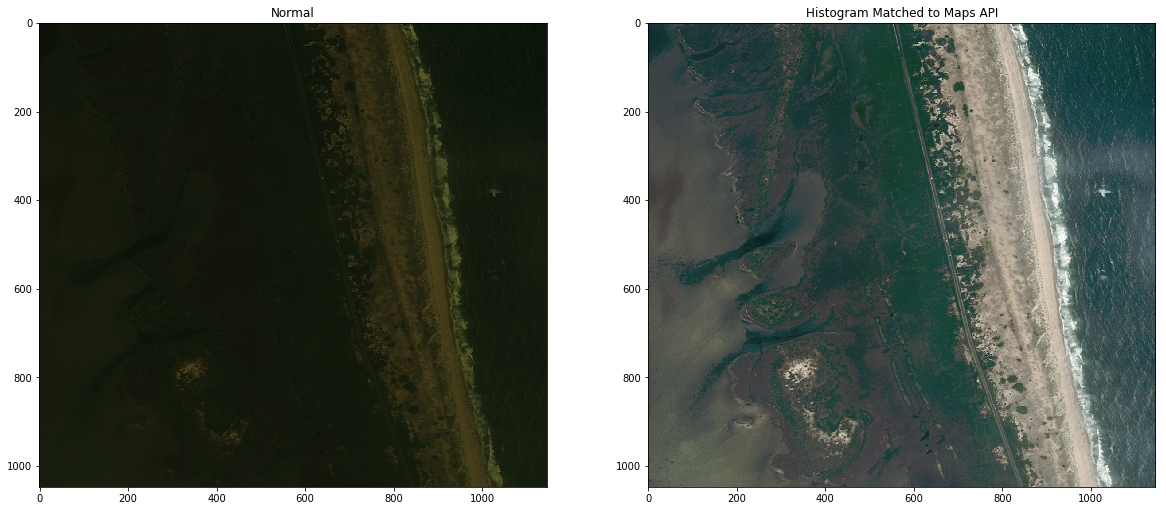

Fetching Image... 20 tiles


Fetching Image... 20 tiles


In [13]:
for region in images:
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.rollaxis(region[[4,2,1], ...].read(), 0, 3))
    plt.title("Normal")
    plt.subplot(1, 2, 2)
    plt.imshow(match_colors_to_ref(region))
    plt.title("Histogram Matched to Maps API")
    plt.show()